In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
sys.dont_write_bytecode = True
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Hardcoded performance behavior of different models. The columns are batchsize, p99 latency in ms, and throughput in qps

In [95]:
resnet_v100 = np.array([
    [1,  132.54010, 10.0],
    [2,  134.24957, 19.7],
    [4,  138.39000, 38.6],
    [8,  149.21285, 76.1],
    [12, 152.38963, 105.2],
    [16, 172.64560, 126.2],
    [24, 212.01610, 168.9],
    [32, 256.63817, 191.5]])
resnet_v100=resnet_v100[np.argsort(resnet_v100[:,0])]
resnet_TXP = np.array([
    [1,  108.87625, 9.9],
    [2,  111.04000, 20.4],
    [4,  121.55254, 39.9],
    [8,  141.82200, 73.6],
    [16, 152.72976, 126.7],
    [32, 278.38175, 151.6]])
resnet_TXP=resnet_TXP[np.argsort(resnet_TXP[:,0])]
inception_v100 = np.array([
    [1,  68.10305,  26.3],
    [2,  72.8235,   45.8],
    [4,  73.88426,  81.5],
    [8,  105.866700, 132.8],
    [12, 112.031640, 179.5],
    [16, 149.952640, 199.5],
    [24, 195.421250, 213.0]])
inception_v100=inception_v100[np.argsort(inception_v100[:,0])]
inception_TXP = np.array([
    [1, 34.84264, 32.4],
    [2, 38.78975, 61.9],
    [4, 57.46735, 103.8],
    [8, 74.90487, 137.7],
    [16, 123.04392, 174.8],
    [32, 216.74803, 203.0]])
inception_TXP=inception_TXP[np.argsort(inception_TXP[:,0])]
ksvm_cpu = np.array([
       [1, 45.305130, 42.3],
       [2, 45.864000, 74.300000],
       [4, 51.040710, 138.40000],
       [8, 54.351710, 276.90000],
       [12, 59.511130, 390.00000],
       [16, 65.195470, 498.70000],
       [24, 75.762700, 655.50000],
       [48, 93.624520, 811.50000],
       [64, 124.36674, 907.80000]])
ksvm_cpu=ksvm_cpu[np.argsort(ksvm_cpu[:,0])]
logreg_cpu = np.array([
       [1, 29.28447, 531.5000],
       [2, 30.27719, 608.6000],
       [4, 31.97647, 1038.900],
       [8, 36.15806, 1094.800]])
logreg_cpu=logreg_cpu[np.argsort(logreg_cpu[:,0])]

In [96]:
import time

start = time.time()
np.save("ibe", inception_TXP.astype(np.float32))
np.save("rbe", resnet_TXP.astype(np.float32))
np.save("lbe", logreg_cpu.astype(np.float32))
np.save("kbe", ksvm_cpu.astype(np.float32))
end = time.time()
print(end - start)

0.00151300430298


### Dictionary from hardware to the model's behavior on that hardware

In [97]:
model_hardware_behavior = {
    "ResNet":    {"TXP":resnet_TXP, "V100":resnet_v100},
    "Inception": {"TXP":inception_TXP, "V100":inception_v100},
    "KSVM":      {"cpu":ksvm_cpu},
    "LogReg":    {"cpu":logreg_cpu}
}

#### Known hardware list and moving around between hardware

In [113]:
# list must be sorted by cost
hardware = [
    ("V100", 2.528),
    ("TXP", 2.1),
    ("cpu", 0.0665)
]

def upgrade_hardware(model, current_hardware):
    # Find index of current_hardware in hardware list
    hardware_list = [hw for hw,_ in hardware]
    index = hardware_list.index(current_hardware)
    while index != 0:
        if hardware_list[index-1] in model_hardware_behavior[model].keys():
            return hardware_list[index-1]
        index-=1
    return None

def downgrade_hardware(model, current_hardware):
    # Find index of current_hardware in hardware list
    hardware_list = [hw for hw,_ in hardware]
    index = hardware_list.index(current_hardware)
    while index != len(hardware)-1:
        if hardware_list[index+1] in model_hardware_behavior[model].keys():
            return hardware_list[index+1]
        index+=1
    return None

def increase_batchsize(model, current_hardware, current_batchsize):
    model_behavior = model_hardware_behavior[model][current_hardware]
    batchsizes = model_behavior[:,0]
    index = list(batchsizes).index(current_batchsize)
    if index == len(batchsizes)-1:
        return None
    else:
        return int(batchsizes[index+1])

def decrease_batchsize(model, current_hardware, current_batchsize):
    model_behavior = model_hardware_behavior[model][current_hardware]
    batchsizes = model_behavior[:,0]
    index = list(batchsizes).index(current_batchsize)
    if index == 0:
        return None
    else:
        return int(batchsizes[index-1])

#### A function to create a x and y points and create a function that represents the segement connection between them

In [99]:
def line_segment_function(x,y):
    def result(x_point):
        assert x_point <= max(x) and x_point >= min(x), "{} out of range of {}".format(x_point, x)
        if x_point in x:
            return y[x == x_point][0]
        less_index = max(np.arange(len(x))[x < x_point])
        more_index = min(np.arange(len(x))[x > x_point])
        rise = y[more_index] - y[less_index]
        run = x[more_index] - x[less_index]
        slope = float(rise)/run
        delta = x_point - x[less_index]
        return y[less_index] + delta*slope
    return result

### A graph representation using nodes as well as a scheduler for simulation purposes

In [100]:
class Scheduler(object):
    # Needed for large values, because np.isclose works on a relative scale. 
    # It'll think that 300000.4 is close to 300000.2 because of the large size of the numbers relative to their difference
    def isclose(self, a, b):
        return np.isclose(a-b, 0)
    
    def __init__(self):
        self.time = 0
        self.scheduled = [] # A list of items scheduled to run, from earliest to latest
    
    # Called by the nodes to schedule fn(time_when_fn_executes) to run in_how_long
    # Adds the function in its schedule time position relative to other scheduled function
    def schedule(self, fn, in_how_long, extra_args = []):
        index = 0
        current_time_to_schedule = self.time + in_how_long
        for item_scheduled_time,_,_ in self.scheduled:
             if item_scheduled_time < current_time_to_schedule:
                index+=1
        self.scheduled.insert(index, [current_time_to_schedule, fn, extra_args])
    
    # continues to pop scheduled functions from the front of the queue until the queue is empty
    # Notice how during execution of the tasks already in the queue more tasks can be scheduled
    def start(self):
        while self.scheduled != []:
            next_event_time, fn, extra_args = self.scheduled.pop(0)
            self.time = next_event_time
            fn(self.time, *extra_args)
            while self.scheduled != [] and self.isclose(self.scheduled[0][0], self.time):
                next_event_time, fn, extra_args = self.scheduled.pop(0)
                fn(self.time, *extra_args)

# Abstract Node class.
class Node(object):
    def __init__(self, name, scheduler):
        self.children = []
        self.parents = []
        self.name = name
        self.scheduler = scheduler
    
    def then(self, child):
        self.children.append(child)
        child.parents.append(self)
    
    def __str__(self):
        return self.name+" Node"
    
    def __repr__(self):
        return self.name+" Node"

# Initialized by taking a query history and a scheduler
# Notice how the queries are actually just dictionary lineages of the node-to-node travel
class SourceNode(Node):
    def __init__(self, deltas, scheduler):
        Node.__init__(self, "source", scheduler)
        self.deltas = deltas
        self.deltas_index = 0
        # Schedule the first query to send
        self.scheduler.schedule(self.send_query, 0)
    
    def send_query(self, time):
        for child in self.children:
            self.scheduler.schedule(child.arrival, 0, extra_args=[[{"id":self.deltas_index, "source":time}]])
        if self.deltas_index < len(self.deltas):
            self.scheduler.schedule(self.send_query, self.deltas[self.deltas_index])
            self.deltas_index+=1

# A regular model node, with a dynamic, greedy batchsize selection scheme (minimum of maximum batchsize and queue size)
# batchsize_p99lat_thru argument is the model-profile array like the one shown in the begining of the notebook
# batching_delay argument dictates how long the model waits from the point that it is idle and receives some query that wakes it up to the point that it actually 
# locks and takes a batchsize from the queue. The reason it was introduced is because longer batching_delay means a more uniform batchsize distribution.
class BatchedNode(Node):
    def __init__(self, max_batch_size, batchsize_p99lat_thru, name, scheduler, num_replicas=1, batching_delay=0, debugging = False):
        Node.__init__(self, name, scheduler)
        self.debugging = debugging
        self.max_batch_size = max_batch_size
        self.batchsize_p99lat_thru = batchsize_p99lat_thru
        self.smoothed_fn = line_segment_function(batchsize_p99lat_thru[:,0], 1/(batchsize_p99lat_thru[:,2]/1000.*batchsize_p99lat_thru[:,0]))
        self.scheduler = scheduler
        self.batching_delay = batching_delay
        self.queue = []
        self.queue_size_over_time = []
        self.batch_sizes_over_time = []
        self.num_replicas = num_replicas
        self.in_model = [[] for _ in range(self.num_replicas)]
        self.model_idle = [True for _ in range(self.num_replicas)]
        self.num_arrivals = 1
    
    def arrival(self, time, query_list):
        self.num_arrivals+=1
        for query in query_list:
            if self.debugging:
                query[self.name+"_enqueue_time"] = time
                self.queue_size_over_time.append([time, len(self.queue)])
        self.queue.extend(query_list)
        import math
        # the number of models that might need waking up, equals to the number of maximum batches in the queue, rounding up
        number_to_wake_up = math.ceil(len(self.queue) / float(self.max_batch_size))
        for model_index in range(len(self.model_idle)):
            if self.model_idle[model_index]:
                self.scheduler.schedule(self.model_take, self.batching_delay, extra_args=[model_index])
                self.model_idle[model_index] = False
                number_to_wake_up-=1
            if number_to_wake_up == 0:
                break
            
    def model_take(self, time, model_index):
        assert len(self.queue) > 0
        num_taken_to_process = min(len(self.queue), self.max_batch_size)
        self.in_model[model_index] = self.queue[:num_taken_to_process]
        self.queue = self.queue[num_taken_to_process:] # dequeue from queue
        if self.debugging:
            for query in self.in_model[model_index]:
                query[self.name+"_dequeue_time"] = time
                query[self.name+"_batchsize"] = num_taken_to_process
            self.queue_size_over_time.append([time, len(self.queue)])
            self.batch_sizes_over_time.append([time, num_taken_to_process])
        self.scheduler.schedule(self.model_return, self.smoothed_fn(num_taken_to_process), extra_args=[model_index]) # service time of batch
    
    def model_return(self, time, model_index):
        if self.debugging:
            for query in self.in_model[model_index]:
                query[self.name+"_service_time"] = time
        query_batch_copy = list(self.in_model[model_index])
        for child in self.children:
            self.scheduler.schedule(child.arrival, 0, extra_args=[query_batch_copy])
        self.in_model[model_index] = []
        if len(self.queue) == 0:
            self.model_idle[model_index] = True
        else:
            self.scheduler.schedule(self.model_take, self.batching_delay, extra_args=[model_index])

# Waits for queries of the same id to arrive from all the parents before sending the union of the lineages to the children
class JoinNode(Node):
    def __init__(self, scheduler, debugging = False):
        Node.__init__(self, "join", scheduler)
        self.debugging = debugging
        self.waiting_values = {} # maps from id to list of queries
    
    def union_dicts(self, dict_list):
        if len(dict_list) == 0:
            return {}
        result = {}
        for dict_element in dict_list:
            result = dict(result, **dict_element)
        return result
    
    def arrival(self, time, query_list):
        query_output_list = []
        for query in query_list:
            query_id = query["id"]
            if self.waiting_values.get(query_id) == None:
                self.waiting_values[query_id] = [query]
            else:
                self.waiting_values[query_id].append(query)
            if len(self.waiting_values[query_id]) == len(self.parents):
                query_union = self.union_dicts(self.waiting_values[query_id])
                query_output_list.append(query_union)
        if query_output_list != []:
            for child in self.children:
                self.scheduler.schedule(child.arrival, 0, extra_args=[query_output_list]) 
        
# Prints every 1000 queries that end up in it, the entire lineage at the end is found at self.queue 
class SinkNode(Node):
    def __init__(self, scheduler):
        Node.__init__(self, "sink", scheduler)
        self.queue = []
        self.counter = 0
    
    def arrival(self, time, query_list):
        for query in query_list:
            self.counter+=1
            if self.counter % 1000 == 0:
                print self.counter
            query["sink"] = time
        self.queue.extend(query_list)

In [101]:
class Scheduler(object):
    # Needed for large values, because np.isclose works on a relative scale. 
    # It'll think that 300000.4 is close to 300000.2 because of the large size of the numbers relative to their difference
    def isclose(self, a, b):
        return np.isclose(a-b, 0)
    
    def __init__(self):
        self.time = 0
        self.scheduled = [] # A list of items scheduled to run, from earliest to latest
    
    # Called by the nodes to schedule fn(time_when_fn_executes) to run in_how_long
    # Adds the function in its schedule time position relative to other scheduled function
    def schedule(self, fn, in_how_long, extra_args = []):
        index = 0
        current_time_to_schedule = self.time + in_how_long
        for item_scheduled_time,_,_ in self.scheduled:
             if item_scheduled_time < current_time_to_schedule:
                index+=1
        self.scheduled.insert(index, [current_time_to_schedule, fn, extra_args])
    
    # continues to pop scheduled functions from the front of the queue until the queue is empty
    # Notice how during execution of the tasks already in the queue more tasks can be scheduled
    def start(self):
        while self.scheduled != []:
            next_event_time, fn, extra_args = self.scheduled.pop(0)
            self.time = next_event_time
            fn(self.time, *extra_args)
            while self.scheduled != [] and self.isclose(self.scheduled[0][0], self.time):
                next_event_time, fn, extra_args = self.scheduled.pop(0)
                fn(self.time, *extra_args)

# Abstract Node class.
class Node(object):
    def __init__(self, name, scheduler):
        self.children = []
        self.parents = []
        self.name = name
        self.scheduler = scheduler
    
    def then(self, child):
        self.children.append(child)
        child.parents.append(self)
    
    def __str__(self):
        return self.name+" Node"
    
    def __repr__(self):
        return self.name+" Node"

# Initialized by taking a query history and a scheduler
# Notice how the queries are actually just dictionary lineages of the node-to-node travel
class SourceNode(Node):
    def __init__(self, deltas, scheduler):
        Node.__init__(self, "source", scheduler)
        self.deltas = deltas
        self.deltas_index = 0
        # Schedule the first query to send
        self.scheduler.schedule(self.send_query, 0)
    
    def send_query(self, time):
        for child in self.children:
            child.arrival(time, [{"id":self.deltas_index, "source":time}])
        if self.deltas_index < len(self.deltas):
            self.scheduler.schedule(self.send_query, self.deltas[self.deltas_index])
            self.deltas_index+=1

# A regular model node, with a dynamic, greedy batchsize selection scheme (minimum of maximum batchsize and queue size)
# batchsize_p99lat_thru argument is the model-profile array like the one shown in the begining of the notebook
# batching_delay argument dictates how long the model waits from the point that it is idle and receives some query that wakes it up to the point that it actually 
# locks and takes a batchsize from the queue. The reason it was introduced is because longer batching_delay means a more uniform batchsize distribution.
class BatchedNode(Node):
    def __init__(self, max_batch_size, batchsize_p99lat_thru, name, scheduler, num_replicas=1, batching_delay=0, debugging = False):
        Node.__init__(self, name, scheduler)
        self.debugging = debugging
        self.max_batch_size = max_batch_size
        self.batchsize_p99lat_thru = batchsize_p99lat_thru
        self.smoothed_fn = line_segment_function(batchsize_p99lat_thru[:,0], 1/(batchsize_p99lat_thru[:,2]/1000.))
        self.scheduler = scheduler
        self.batching_delay = batching_delay
        self.queue = []
        self.queue_size_over_time = []
        self.batch_sizes_over_time = []
        self.num_replicas = num_replicas
        self.in_model = [[] for _ in range(self.num_replicas)]
        self.model_idle = [True for _ in range(self.num_replicas)]
        self.num_arrivals = 1
    
    def arrival(self, time, query_list):
        self.num_arrivals+=1
        for query in query_list:
            if self.debugging:
                query[self.name+"_enqueue_time"] = time
                self.queue_size_over_time.append([time, len(self.queue)])
        self.queue.extend(query_list)
        import math
        # the number of models that might need waking up, equals to the number of maximum batches in the queue, rounding up
        number_to_wake_up = math.ceil(len(self.queue) / float(self.max_batch_size))
        for model_index in range(len(self.model_idle)):
            if self.model_idle[model_index]:
                self.model_idle[model_index] = False
                if self.batching_delay != 0:
                    self.scheduler.schedule(self.model_take, self.batching_delay, extra_args=[model_index])
                else:
                    self.model_take(time, model_index)
                number_to_wake_up-=1
            if number_to_wake_up == 0:
                break
            
    def model_take(self, time, model_index):
        assert len(self.queue) > 0
        num_taken_to_process = min(len(self.queue), self.max_batch_size)
        self.in_model[model_index] = self.queue[:num_taken_to_process]
        self.queue = self.queue[num_taken_to_process:] # dequeue from queue
        if self.debugging:
            for query in self.in_model[model_index]:
                query[self.name+"_dequeue_time"] = time
                query[self.name+"_batchsize"] = num_taken_to_process
            self.queue_size_over_time.append([time, len(self.queue)])
            self.batch_sizes_over_time.append([time, num_taken_to_process])
        self.scheduler.schedule(self.model_return, self.smoothed_fn(num_taken_to_process), extra_args=[model_index]) # service time of batch
    
    def model_return(self, time, model_index):
        if self.debugging:
            for query in self.in_model[model_index]:
                query[self.name+"_service_time"] = time
        query_batch_copy = list(self.in_model[model_index])
        for child in self.children:
            child.arrival(time, query_batch_copy)
        self.in_model[model_index] = []
        if len(self.queue) == 0:
            self.model_idle[model_index] = True
        else:
            if self.batching_delay != 0:
                self.scheduler.schedule(self.model_take, self.batching_delay, extra_args=[model_index])
            else:
                self.model_take(time, model_index)

# Waits for queries of the same id to arrive from all the parents before sending the union of the lineages to the children
class JoinNode(Node):
    def __init__(self, scheduler, debugging = False):
        Node.__init__(self, "join", scheduler)
        self.debugging = debugging
        self.waiting_values = {} # maps from id to list of queries
    
    def union_dicts(self, dict_list):
        if len(dict_list) == 0:
            return {}
        result = {}
        for dict_element in dict_list:
            result = dict(result, **dict_element)
        return result
    
    def arrival(self, time, query_list):
        query_output_list = []
        for query in query_list:
            query_id = query["id"]
            if self.waiting_values.get(query_id) == None:
                self.waiting_values[query_id] = [query]
            else:
                self.waiting_values[query_id].append(query)
            if len(self.waiting_values[query_id]) == len(self.parents):
                query_union = self.union_dicts(self.waiting_values[query_id])
                query_output_list.append(query_union)
        if query_output_list != []:
            for child in self.children:
                child.arrival(time, query_output_list)
        
# Prints every 1000 queries that end up in it, the entire lineage at the end is found at self.queue 
class SinkNode(Node):
    def __init__(self, scheduler):
        Node.__init__(self, "sink", scheduler)
        self.queue = []
        self.counter = 0
    
    def arrival(self, time, query_list):
        for query in query_list:
            self.counter+=1
            if self.counter % 1000 == 0:
                print self.counter
            query["sink"] = time
        self.queue.extend(query_list)

### Define Image Driver 1 and related utilities

In [172]:
example_image_driver_1_config = {
    "ResNet":    {"bs":1, "rf": 1, "hw":"V100"},
    "Inception": {"bs":1, "rf": 1, "hw":"V100"},
    "KSVM":      {"bs":1, "rf": 1, "hw":"cpu"},
    "LogReg":    {"bs":1, "rf": 1, "hw":"cpu"}
}

def config_cost(model_configs):
    hardware_dict = {k:v for k,v in hardware}
    total = 0
    for model in model_configs:
        model_cost = hardware_dict[model_configs[model]["hw"]]*model_configs[model]["rf"]
        total+=model_cost
    return total

def model_behavior_from_config(model, config):
    return model_hardware_behavior[model][config[model]["hw"]]

def get_throughput(model, hardware, batchsize):
    model_behavior = model_hardware_behavior[model][hardware]
    return model_behavior[list(model_behavior[:,0]).index(batchsize), 2]

# Returns maximum end-to-end throughput of pipeline (assuming maximum batchsize)
def end_to_end_max_throughput(model_configs):
    def get_throughput_for_model(model):
        bs = model_configs[model]["bs"]
        model_behavior = model_behavior_from_config(model, model_configs)
        single_replica_throughput = model_behavior[model_behavior[:,0] == bs][0][2]
        return single_replica_throughput*model_configs[model]["rf"]
    resnet_throughput = get_throughput_for_model("ResNet")
    inception_througput = get_throughput_for_model("Inception")
    ksvm_throughput = get_throughput_for_model("KSVM")
    logreg_latency = get_throughput_for_model("LogReg")
    resnet_branch = min(resnet_throughput, ksvm_throughput)
    inception_branch = min(inception_througput, logreg_latency)
    return min(resnet_branch, inception_branch)

def throughput_bottleneck(model_configs):
    def get_throughput_for_model(model):
        bs = model_configs[model]["bs"]
        model_behavior = model_behavior_from_config(model, model_configs)
        single_replica_throughput = model_behavior[model_behavior[:,0] == bs][0][2]
        return single_replica_throughput*model_configs[model]["rf"]
    throughput_dict = {m:get_throughput_for_model(m) for m in model_configs}
    return min(throughput_dict, key=throughput_dict.get)

def end_to_end_minimum_latency(model_configs):
    def get_latency_for_batchsize(model):
        bs = model_configs[model]["bs"]
        model_behavior = model_behavior_from_config(model, model_configs)
        return model_behavior[model_behavior[:, 0] == bs][0][1]
    resnet_latency = get_latency_for_batchsize("ResNet")
    inception_latency = get_latency_for_batchsize("Inception")
    ksvm_latency = get_latency_for_batchsize("KSVM")
    logreg_latency = get_latency_for_batchsize("LogReg")
    resnet_branch = resnet_latency + ksvm_latency
    inception_branch = inception_latency + logreg_latency
    return max(resnet_branch, inception_branch)

def extract_deltas(deltas_file):
    with open(deltas_file, 'r') as f:
        deltas = np.array([float(l.strip()) for l in f]).flatten()
    return deltas
        
def get_end_to_end_times(model_configs, deltas):
    scheduler = Scheduler()
    source = SourceNode(deltas, scheduler)
    def create_batched_node(model):
        return BatchedNode(max_batch_size=model_configs[model]["bs"], 
                           batchsize_p99lat_thru=model_behavior_from_config(model, model_configs), 
                           name=model, scheduler=scheduler, batching_delay=0, 
                           num_replicas=model_configs[model]["rf"]) 
    inception = create_batched_node("Inception")
    resnet    = create_batched_node("ResNet")
    ksvm      = create_batched_node("KSVM")
    logreg    = create_batched_node("LogReg")
    join = JoinNode(scheduler)
    sink = SinkNode(scheduler)
    source.then(resnet)
    source.then(inception)
    inception.then(logreg)
    resnet.then(ksvm)
    logreg.then(join)
    ksvm.then(join)
    join.then(sink)
    scheduler.start()
    final_lineage_result = sink.queue
    return final_lineage_result

def get_end_to_end_times_cpp(model_configs, deltas_file):
    inception_name = "ibe_"+model_configs["Inception"]["hw"]
    ksvm_name = "kbe_"+model_configs["KSVM"]["hw"]
    resnet_name = "rbe_"+model_configs["ResNet"]["hw"]
    logreg_name = "lbe_"+model_configs["LogReg"]["hw"]
    np.save(inception_name, model_behavior_from_config("Inception", model_configs).astype(np.float32))
    np.save(ksvm_name, model_behavior_from_config("KSVM", model_configs).astype(np.float32))
    np.save(resnet_name, model_behavior_from_config("ResNet", model_configs).astype(np.float32))
    np.save(logreg_name, model_behavior_from_config("LogReg", model_configs).astype(np.float32))
    call_list = [
        "./simulation.o",
        "--irf", str(model_configs["Inception"]["rf"]), "--ibe",inception_name+".npy", "--ibs", str(model_configs["Inception"]["bs"]),
        "--krf", str(model_configs["KSVM"]["rf"]), "--kbe", ksvm_name+".npy", "--kbs", str(model_configs["KSVM"]["bs"]),
        "--rrf", str(model_configs["ResNet"]["rf"]), "--rbe", resnet_name+".npy", "--rbs", str(model_configs["ResNet"]["bs"]),
        "--lrf", str(model_configs["LogReg"]["rf"]), "--lbe", logreg_name+".npy", "--lbs", str(model_configs["LogReg"]["bs"]),
        "--result_file", "end_to_end_times.txt", 
        "--deltas", deltas_file,
    ]
#     print ' '.join(call_list)
    import subprocess
    import os
    p = subprocess.Popen(' '.join(call_list), shell=True, stdin=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = p.communicate()
#     print stdout
#     print stderr
    assert p.wait() == 0
    with open("end_to_end_times.txt", 'r') as f:
        end_to_end_times = np.array([float(l.strip()) for l in f]).flatten()
    return end_to_end_times

def check_feasibility(model_configs, deltas, deltas_file, slo):
    mean_arrival_throughput = 1/np.mean(deltas)*1000 # average arrival throughput in qps
    max_pipeline_throughput = end_to_end_max_throughput(model_configs) # max throughput in qps
    if mean_arrival_throughput > max_pipeline_throughput:
        print "Mean arrival throughput: {}, max_pipeline_throughput: {}".format(mean_arrival_throughput, max_pipeline_throughput)
        return False
    min_pipeline_latency = end_to_end_minimum_latency(model_configs) # min latency in ms
    if min_pipeline_latency > slo:
        print "min_pipeline_latency: {}, Latency SLO: {}".format(min_pipeline_latency, slo)
        return False
#     final_lineage_result = get_end_to_end_times(model_configs, deltas)
#     end_to_end_times = [x["sink"] - x["source"] for x in final_lineage_result]
    end_to_end_times_cpp = get_end_to_end_times_cpp(model_configs, deltas_file)
#     plt.scatter(np.arange(len(end_to_end_times)), end_to_end_times, label="Python")
#     plt.scatter(np.arange(len(end_to_end_times_cpp)), end_to_end_times_cpp, label="C++")
#     plt.legend()
#     plt.show()
    print "Max end to end time: {}".format(np.max(end_to_end_times_cpp))
#     if np.max(end_to_end_times) > slo:
    if np.max(end_to_end_times_cpp) > slo:
        print "Maximum end to end time: {}, Latency SLO: {}".format(np.max(end_to_end_times_cpp), slo)
        return False
    return True

## Optimizers

In [173]:
def throughput_maximizer(cost, slo, deltas):
    # Start with bs=1, rf=1, hw=smallest for all models
    initial_config = {
        "ResNet":    {"bs":1, "rf": 1, "hw":"TXP"},
        "Inception": {"bs":1, "rf": 1, "hw":"TXP"},
        "KSVM":      {"bs":1, "rf": 1, "hw":"cpu"},
        "LogReg":    {"bs":1, "rf": 1, "hw":"cpu"}
    }
    deltas = extract_deltas(deltas_file)
    something_changed = True
    found = False
    while something_changed:
        if check_feasibility(initial_config, deltas, deltas_file, slo) and config_cost(initial_config) <= cost:
            found = True
            break
        something_changed = False
        # in each iteration, find bottleneck model
        bm = throughput_bottleneck(initial_config)
        # try to upgrade by first increasing batchsize
        next_batchsize = increase_batchsize(bm, initial_config[bm]["hw"], initial_config[bm]["bs"])
        if next_batchsize != None:
            initial_config[bm]["bs"] = next_batchsize
            something_changed = True
            continue
        # then increasing rf
        old_rf = initial_config[bm]["rf"]
        initial_config[bm]["rf"] = old_rf+1
        if config_cost(initial_config) <= cost:
            something_changed = True
            continue
        else:
            initial_config[bm]["rf"] = old_rf
        # then upgrading hardware
        downgraded_hardware = downgrade_hardware(bm, initial_config[bm]["hw"])
        if downgraded_hardware != None:
            old_hardware = initial_config[bm]["hw"]
            initial_config[bm]["hw"] = downgraded_hardware
            if config_cost(initial_config) <= cost:
                something_changed = True
                continue
            else:
                initial_config[bm]["hw"] = old_hardware
    # if none of these steps work, then you're done
    # otherwise continue iterating
    if found:
        return initial_config
    else:
        return None

def bruteforce_optimizer(cost, slo, deltas):
    # Get the maximum rf needed for each model (when its batchsize is 1 and hw is the lowest) and set that as the bound of rf range to look at
    # lowest_cost_seen = np.inf
    # Pick a configuration at random
    # If its cost is less than lowest_cost_seen then check feasibility, otherwise skip it and prune all configurations more expensive than it
    # If its feasible then update lowest_cost_seen, and prune all configurations 
    # Start at a random configuration
    pass

def cost_minimizer(slo, deltas_file):
    # Start configuration with bs=1, rf=N, hw=largest for all models, where N is the minimum number of rfs needed to make the pipeline feasible
    initial_config = {
        "ResNet":    {"bs":1, "rf": 1, "hw":"V100"},
        "Inception": {"bs":1, "rf": 1, "hw":"V100"},
        "KSVM":      {"bs":1, "rf": 1, "hw":"cpu"},
        "LogReg":    {"bs":1, "rf": 1, "hw":"cpu"}
    }
    deltas = extract_deltas(deltas_file)
    arrival_lambda = 1/np.mean(deltas)*1000.
    import math
    for m in initial_config:
        throughput = get_throughput(m, initial_config[m]["hw"], initial_config[m]["bs"])
        replicas = int(math.ceil(arrival_lambda / throughput))
        initial_config[m]["rf"] = replicas*2
    print initial_config
    assert check_feasibility(initial_config, deltas, deltas_file, slo)
    something_changed = True
    while something_changed:
        something_changed = False
        # in each iteration, iterate through all of the models
        for m in initial_config:
            next_batchsize = increase_batchsize(m, initial_config[m]["hw"], initial_config[m]["bs"])
            if next_batchsize != None:
                old_batchsize = initial_config[m]["bs"]
                initial_config[m]["bs"] = next_batchsize
                if check_feasibility(initial_config, deltas, deltas_file, slo):
#                     print m, "batchsize", initial_config
                    something_changed = True
                else:
                    initial_config[m]["bs"] = old_batchsize
            if initial_config[m]["rf"] > 1:
                initial_config[m]["rf"]-=1
                if check_feasibility(initial_config, deltas, deltas_file, slo):
#                     print m, "replication factor", initial_config
                    something_changed = True
                else:
                    initial_config[m]["rf"]+=1
            downgraded_hardware = downgrade_hardware(m, initial_config[m]["hw"])
            if downgraded_hardware != None:
                old_hardware = initial_config[m]["hw"]
                initial_config[m]["hw"] = downgraded_hardware
                if check_feasibility(initial_config, deltas, deltas_file, slo):
#                     print m, "hardware", initial_config
                    something_changed = True
                else:
                    initial_config[m]["hw"] = old_hardware
        if not something_changed:
            break
    return initial_config
    # for each model, see if you can increase the batchsize, then decrease the rf, then to downgrade hardware
    # iteration ends when none of the models could be changed

In [174]:
def config_cost_none(a):
    if a == None:
        return None
    else:
        return config_cost(a)

In [176]:
final_dict = {}
for cv in [0.1,4.0]:
    for lambd in [50,100,250,500]:
        for slo in [350,500]:
            deltas_file = "/data/ges/plots-model-comp-paper/experiments/cached_arrival_processes/{}_{}.deltas".format(lambd, cv)
            cost_minimizer_config = cost_minimizer(slo, deltas_file)
            final_cost = config_cost(cost_minimizer_config)
            thru_maximizer_config = throughput_maximizer(final_cost, slo, deltas_file)
            thru_maximizer_config_harder = throughput_maximizer(final_cost-0.1, slo, deltas_file)
            if thru_maximizer_config_harder != None:
                assert config_cost(thru_maximizer_config_harder) <= final_cost-0.1
                print config_cost(thru_maximizer_config_harder), final_cost-0.1
            final_dict[(cv, lambd, slo)] = (cost_minimizer_config, thru_maximizer_config, thru_maximizer_config_harder)
            
            

{'Inception': {'rf': 4, 'hw': 'V100', 'bs': 1}, 'KSVM': {'rf': 4, 'hw': 'cpu', 'bs': 1}, 'ResNet': {'rf': 10, 'hw': 'V100', 'bs': 1}, 'LogReg': {'rf': 2, 'hw': 'cpu', 'bs': 1}}
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 123.671875
Max end to end time: 124.671875
Max end to end time: 124.671875
Max end to end time: 124.671875
Max end to end time: 124.671875
Max end to end time: 124.671875
Max end to end time: 124.671875
Max end to end time: 136.0625
Max end to end time: 136.0625
Max end to end time: 136.0625
Max end to end time: 136.0625
Max end to end time: 136.0625
Max end to end time: 136.0625
Max end to end time: 136.0625
Max end to end time: 155.375
Max end to end time: 155.375
Max end to end time: 160.875
Max end to end time: 160.875
Max end to end time: 160.875
Max end to end time:

In [177]:
final_dict

{(0.1,
  50,
  350): ({'Inception': {'bs': 32, 'hw': 'TXP', 'rf': 1},
   'KSVM': {'bs': 16, 'hw': 'cpu', 'rf': 1},
   'LogReg': {'bs': 8, 'hw': 'cpu', 'rf': 1},
   'ResNet': {'bs': 32, 'hw': 'TXP', 'rf': 1}}, {'Inception': {'bs': 2,
    'hw': 'TXP',
    'rf': 1},
   'KSVM': {'bs': 2, 'hw': 'cpu', 'rf': 1},
   'LogReg': {'bs': 1, 'hw': 'cpu', 'rf': 1},
   'ResNet': {'bs': 8, 'hw': 'TXP', 'rf': 1}}, None),
 (0.1,
  50,
  500): ({'Inception': {'bs': 32, 'hw': 'TXP', 'rf': 1},
   'KSVM': {'bs': 64, 'hw': 'cpu', 'rf': 1},
   'LogReg': {'bs': 8, 'hw': 'cpu', 'rf': 1},
   'ResNet': {'bs': 32, 'hw': 'TXP', 'rf': 1}}, {'Inception': {'bs': 2,
    'hw': 'TXP',
    'rf': 1},
   'KSVM': {'bs': 2, 'hw': 'cpu', 'rf': 1},
   'LogReg': {'bs': 1, 'hw': 'cpu', 'rf': 1},
   'ResNet': {'bs': 8, 'hw': 'TXP', 'rf': 1}}, None),
 (0.1,
  100,
  350): ({'Inception': {'bs': 32, 'hw': 'TXP', 'rf': 1},
   'KSVM': {'bs': 16, 'hw': 'cpu', 'rf': 1},
   'LogReg': {'bs': 8, 'hw': 'cpu', 'rf': 1},
   'ResNet': {'bs': 32

In [178]:
{k:(config_cost_none(a), config_cost_none(b), config_cost_none(c)) for k,(a,b,c) in final_dict.items()}

{(0.1, 50, 350): (4.333, 4.333, None),
 (0.1, 50, 500): (4.333, 4.333, None),
 (0.1, 100, 350): (4.333, 4.333, None),
 (0.1, 100, 500): (4.333, 4.333, None),
 (0.1, 250, 350): (10.633000000000001, 10.633000000000001, None),
 (0.1, 250, 500): (8.533, 8.533, None),
 (0.1, 500, 350): (37.9995, None, None),
 (0.1, 500, 500): (14.833, 14.833, None),
 (4.0, 50, 350): (12.732999999999999, None, None),
 (4.0, 50, 500): (4.333, 4.333, None),
 (4.0, 100, 350): (12.732999999999999, 10.633000000000001, 10.633000000000001),
 (4.0, 100, 500): (6.433, 6.433, None),
 (4.0, 250, 350): (33.733, None, None),
 (4.0, 250, 500): (10.633000000000001, 10.633000000000001, None),
 (4.0, 500, 350): (31.699500000000004, None, None),
 (4.0, 500, 500): (14.833, 14.833, None)}

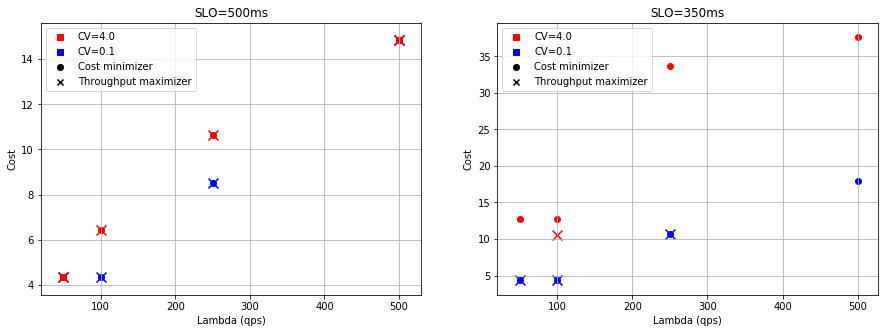

In [226]:
lambdas = [50,100,250,500]

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("SLO=500ms")
plt.ylabel("Cost")
plt.xlabel("Lambda (qps)")
plt.grid()
result = np.array([4.333,4.333,8.533,14.833])
plt.scatter(lambdas, result, marker="o", color="blue") #0.1
result = np.array([4.333,4.333,8.533,14.833])
plt.scatter(lambdas, result, marker="x", s=100, color="blue") #4.0
result = np.array([4.333,6.433,10.633,14.833])
plt.scatter(lambdas, result, marker="o", color="red") #0.1
result = np.array([4.333,6.433,10.633,14.833])
plt.scatter(lambdas, result, marker="x", s=100, color="red") #4.0
plt.scatter([],[],marker='s',color="red",label="CV=4.0")
plt.scatter([],[],marker='s',color="blue",label="CV=0.1")
plt.scatter([],[],marker='o',color="black",label="Cost minimizer")
plt.scatter([],[],marker='x',color="black",label="Throughput maximizer")
plt.legend()

plt.subplot(1,2,2)
plt.title("SLO=350ms")
plt.ylabel("Cost")
plt.xlabel("Lambda (qps)")
plt.grid()
result = np.array([4.333, 4.333, 10.633000000000001, 17.9995])
plt.scatter(lambdas, result, marker="o", color="blue") #0.1
result = np.array([4.333, 4.333, 10.633, np.nan])
plt.scatter(lambdas, result, marker="x", s=100, color="blue") #4.0
result = np.array([12.732999999999999,  12.732999999999999, 33.733, 37.699500000000004])
plt.scatter(lambdas, result, marker="o", color="red") #0.1
result = np.array([np.nan, 10.633, np.nan, np.nan])
plt.scatter(lambdas, result-0.15, marker="x", s=100, color="red") #4.0
plt.scatter([],[],marker='s',color="red",label="CV=4.0")
plt.scatter([],[],marker='s',color="blue",label="CV=0.1")
plt.scatter([],[],marker='o',color="black",label="Cost minimizer")
plt.scatter([],[],marker='x',color="black",label="Throughput maximizer")
plt.legend()

In [236]:
example_image_driver_1_config = {
    "ResNet":    {"bs":8, "rf": 1, "hw":"TXP"},
    "Inception": {"bs":8, "rf": 1, "hw":"TXP"},
    "KSVM":      {"bs":2, "rf": 1, "hw":"cpu"},
    "LogReg":    {"bs":1, "rf": 1, "hw":"cpu"}
}
cv=0.1
lambd=30
slo = 500
deltas_file = "/data/ges/plots-model-comp-paper/experiments/cached_arrival_processes/{}_{}.deltas".format(lambd, cv)
deltas = extract_deltas(deltas_file)
check_feasibility(example_image_driver_1_config, deltas, deltas_file, slo)

Max end to end time: 228.40625


True

In [240]:
bottleneck = throughput_bottleneck(example_image_driver_1_config)
bottleneck

'ResNet'

In [233]:
get_throughput(bottleneck, example_image_driver_1_config[bottleneck]["hw"], example_image_driver_1_config[bottleneck]["bs"])

73.6

In [238]:
planner_result = cost_minimizer(500, deltas_file)

{'Inception': {'rf': 4, 'hw': 'V100', 'bs': 1}, 'KSVM': {'rf': 2, 'hw': 'cpu', 'bs': 1}, 'ResNet': {'rf': 8, 'hw': 'V100', 'bs': 1}, 'LogReg': {'rf': 2, 'hw': 'cpu', 'bs': 1}}
Max end to end time: 124.5
Max end to end time: 124.5
Max end to end time: 124.5
Max end to end time: 124.5
Max end to end time: 124.5
Max end to end time: 150.4375
Max end to end time: 150.4375
Max end to end time: 150.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 151.4375
Max end to end time: 158.25
Max end to end time: 158.25
Max end to end time: 158.25
Max end to end time: 158.25
Max end to end time: 158.25
Max end to end time: 160.1875
Max end to end time: 160.1875
Max end t

In [239]:
planner_result

{'Inception': {'bs': 32, 'hw': 'TXP', 'rf': 1},
 'KSVM': {'bs': 64, 'hw': 'cpu', 'rf': 1},
 'LogReg': {'bs': 8, 'hw': 'cpu', 'rf': 1},
 'ResNet': {'bs': 32, 'hw': 'TXP', 'rf': 1}}

In [243]:
bottleneck = throughput_bottleneck(planner_result)
print bottleneck
get_throughput(bottleneck, planner_result[bottleneck]["hw"], planner_result[bottleneck]["bs"])

ResNet


151.6

In [245]:
cv=4.0
lambd=30
slo = 500
deltas_file = "/data/ges/plots-model-comp-paper/experiments/cached_arrival_processes/{}_{}.deltas".format(lambd, cv)
check_feasibility(planner_result, deltas, deltas_file, slo)

Max end to end time: 321.75


True